<a href="https://colab.research.google.com/github/shlok-py/fox_news_Data_analysis_web_scraping/blob/main/web_scraping_and_data_anal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In this program "*web_Scraping_and_data_anal.py*" I scraped out some key data from foxnews.com and did data analysis on its news, sentimental analysis, frequency analysis and many more.
Now, let's begin this.

# STEP 1. Importing Dependencies


In [1]:
from bs4 import BeautifulSoup
import requests

## 1.2 Giving the static URL 
And using request response to get the html

In [2]:
url = "https://www.foxnews.com/"
response = requests.get(url).text

## 1.3 Parsing response using html.parser

In [3]:
soup = BeautifulSoup(response, 'html.parser')

## 1.4 checking if the code works using soup.title

In [4]:
soup.title

<title>Fox News - Breaking News Updates | Latest News Headlines | Photos &amp; News Videos</title>

#STEP 2. Scrape the title from the homepage from foxnews.com

In [ ]:
#scrape the title
titles = soup.find_all('h3', class_= 'title')
news_titles = []
for title in titles:
    anchor_tag = title.find('a')
    if anchor_tag == None:
      news_titles.append(None)
      continue
    print(anchor_tag.text.strip())
    news_titles.append(anchor_tag.text.strip())

#STEP 3. Scrape the URL from the homepage from foxnews.com

In [ ]:
#scrpe the url
urls = []
for link in titles:
  url = link.find('a')
  if url == None:
    urls.append(None)
    continue
  urls.append(url['href'])
for i in range(len(urls)):
  if urls[i]!=None:
    if not urls[i].startswith('https:'):
      urls[i] = 'https:' + urls[i]
urls

# STEP 4: Scrape the news Corpus

In [ ]:
#scrape the news corpus
art_text = []
for url in urls:
  try:
    response = requests.get(url).text
    f_texts = BeautifulSoup(response, 'html.parser')
    main_text = f_texts.find('div', class_='article-body')
    if main_text == None:
      art_text.append(None)
      continue
    article_text = main_text.get_text()
    print(article_text.strip())
    art_text.append(article_text.strip())
  except requests.exceptions.RequestException as e:
    # Handle the exception (e.g. log an error message, skip the URL, etc.)
    print(f'Error while requesting {url}: {e}')
    art_text.append(None)
    continue
len(art_text)

# STEP 5: Scrape the news category

In [ ]:
#find the news category
from urllib.parse import urlparse
news_cat = []
for url in urls:
  url_parts = urlparse(url)
  print(url)
  if url == None:
    news_cat.append(None)
    continue
  path_parts = url_parts.path.split('/')
  category = path_parts[1] if len(path_parts) > 1 else ' '
  news_cat.append(category)

# STEP 6: Scrape Authors Name

In [9]:
#scraping the authors
author_names = []
for url in urls:
  if url == None:
    author_names.append(None)
    continue
  response = requests.get(url)

  soup = BeautifulSoup(response.text, 'html.parser')

  # Find the element containing the author name
  author_element = soup.find('a', class_='author-byline')
  if author_element:
      # Extract the author name from the element
      author_name = author_element.text.strip()
      author_names.append(author_name)
  else:
      # If the author element is not found, set the author name to an empty string
      author_name = ''
      author_names.append(author_name)

# STEP 7: Scrape date and time

In [53]:
# Scrape the time and date
time = []
for url in urls:
  if url == None:
    time.append(None)
    continue
  response = requests.get(url)
  soup = BeautifulSoup(response.text, 'html.parser')
  news_dates = soup.find('time')
  if news_dates == None:
    time.append(None)
    continue
  time.append(news_dates.get_text())
print(news_dates.get_text()[:-3])


 March 18, 2023 2:00pm 


In [ ]:
time

# STEP 8: Convert everything into pandas DataFrame

In [55]:
import pandas as pd
news_data = pd.DataFrame({
    "Title": news_titles,
    "Link": urls,
    "Corpus": art_text,
    "category": news_cat,
    "author": author_names,
    "timeanddate": time,
})
news_data.dropna(how='any', inplace=True)

# STEP 9: Sentimental Analysis
### download nltk dependencies

In [38]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# Download stop words
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [39]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

## 9.1 Remove Stopwords and uneccessary words from the corpus

In [56]:
# Define function to remove stop words
stop_words = set(stopwords.words('english'))
stop_words.update(['close', 2, ':', 3, 'video', 'fox news', 'flash', 'top', 'headlines'])
def remove_stopwords(text):
    if text != None:
      tokens = word_tokenize(text.lower())
      filtered_tokens = [word for word in tokens if word not in stop_words]
      return ' '.join(filtered_tokens)

# Apply function to 'corpus' column
news_data['Corpus'] = news_data['Corpus'].apply(remove_stopwords)

### See the new Corpus

In [57]:
news_data["Corpus"]

0      world cancer day cancer survivor 's story brea...
1      washington homeowner claims squatters took pro...
2      indoctrination schools 'needs stop ' says scho...
3      fox news entertainment week fox news entertain...
4      woman quits job take care husband like 1950s h...
                             ...                        
144    good samaritan helped stop gym attacker good s...
149    fox news march 15 fox news . check 's clicking...
150    fox news march 15 fox news . check 's clicking...
151    turkey earthquake captured dashcam dashcam cap...
152    fox news march 15 fox news . check 's clicking...
Name: Corpus, Length: 143, dtype: object

## 9.2 Sentiment Analysis
### Positive Negative or Neutral

In [58]:
from textblob import TextBlob
def get_sentiment(text):
    blob = TextBlob(text)
    sentiment_score = blob.sentiment.polarity
    if sentiment_score > 0:
        return 'positive'
    elif sentiment_score < 0:
        return 'negative'
    else:
        return 'neutral'
news_data['sentiment'] = news_data['Corpus'].apply(get_sentiment)

In [59]:
news_data.head()

,Title,Link,Corpus,category,author,timeanddate,sentiment
0,Pentagon study shows concerning health diagnos...,https://www.foxnews.com/health/military-pilots...,world cancer day cancer survivor 's story brea...,health,,"March 19, 2023 12:46pm EDT",positive
1,Woman desperately tries to reclaim mom's home ...,https://www.foxnews.com/us/chicago-family-figh...,washington homeowner claims squatters took pro...,us,,"March 19, 2023 10:21am EDT",positive
2,"Anti-capitalist teacher promotes anarchy, stud...",https://www.foxnews.com/media/anti-capitalist-...,indoctrination schools 'needs stop ' says scho...,media,,"March 19, 2023 8:00am EDT",positive
3,Ben Affleck reveals who Michael Jordan request...,https://www.foxnews.com/entertainment/ben-affl...,fox news entertainment week fox news entertain...,entertainment,,"March 19, 2023 11:44am EDT",positive
4,'Tradwives' slam critics who call their viral ...,https://www.foxnews.com/lifestyle/tradwives-pu...,woman quits job take care husband like 1950s h...,lifestyle,,"March 19, 2023 10:42am EDT",positive


In [60]:
news_data.tail()

,Title,Link,Corpus,category,author,timeanddate,sentiment
144,Hatchet-wielding attacker subdued during wild ...,https://www.foxnews.com/media/hatchet-wielding...,good samaritan helped stop gym attacker good s...,media,,"March 17, 2023 1:15pm EDT",positive
149,Grand Canyon National Park planning for a $208...,https://www.foxnews.com/us/grand-canyon-nation...,fox news march 15 fox news . check 's clicking...,us,,"March 19, 2023 9:00am EDT",positive
150,"Only big whales can lunge-feed successfully, a...",https://www.foxnews.com/science/only-big-whale...,fox news march 15 fox news . check 's clicking...,science,,"March 19, 2023 8:00am EDT",positive
151,Strong earthquake kills at least 14 in Ecuador...,https://www.foxnews.com/world/strong-earthquak...,turkey earthquake captured dashcam dashcam cap...,world,,"March 18, 2023 9:59pm EDT",negative
152,London partygoers rave to AI-generated beats i...,https://www.foxnews.com/entertainment/london-p...,fox news march 15 fox news . check 's clicking...,entertainment,,"March 18, 2023 2:00pm EDT",positive


In [22]:
grouped_Data = news_data.groupby('category')

In [23]:
counts = grouped_Data['Title'].count()
print(counts)

category
auto                 4
earth-space          1
economy              1
entertainment       16
extreme-weather      2
food-drink           4
health               8
lifestyle           10
markets              1
media               15
opinion             11
personal-finance     3
politics            11
retail               2
science              1
sports              10
tech                 5
technology           2
us                  24
weather-news         1
world               11
Name: Title, dtype: int64


In [24]:
count = counts.tolist()

In [25]:
categories = news_data['category'].unique().tolist()

# STEP 10: Visualising news volume w.r.t categories
## Visualize on the basis of news category. For eg: Politics, Science

In [ ]:
category_counts = news_data['category'].value_counts()
print(category_counts)

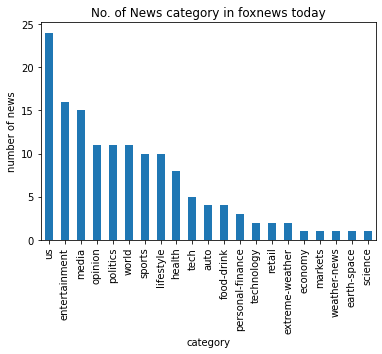

In [27]:
import matplotlib.pyplot as plt
category_counts.plot(kind='bar')
plt.title("No. of News category in foxnews today")
plt.xlabel("category")
plt.ylabel("number of news")
plt.show()

# Graph Analysis

In [ ]:
sentiment_counts = news_data['sentiment'].value_counts()
print(category_counts)

## The pie below shows that more of **positive** news have been published than **negative** news recently in *foxnews.com*.

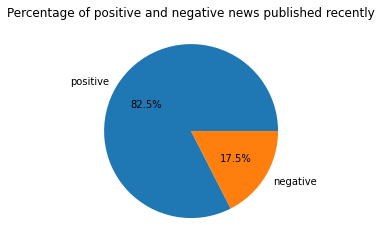

In [84]:
plt.pie(sentiment_counts.values, labels=sentiment_counts.index, autopct='%1.1f%%')

plt.title("Percentage of positive and negative news published recently")
plt.show()

# Category + Sentiment Analysis
## Lets analyse which category is likely to have more positive or negative news recently

In [ ]:
category_counts = news_data.groupby(['category', 'sentiment']).size().reset_index(name = 'count')
print(category_counts)

In [80]:
pivot_table = category_counts.pivot(index='category', columns='sentiment', values='count')

## The chart below depicts the sentiment and category relation of news corpus. Here we can see that the **weather** category brings most of the bad or negative news where as **market** is going down as it also carries negative news. Besides, Media, Politics, tech, US and world has balanced positive and negative news. We cannot see any neutral news in foxnews.com 

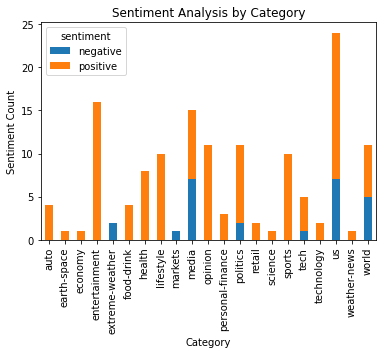

In [79]:
pivot_table.plot(kind='bar', stacked=True)

# add labels and a title to the chart
plt.xlabel('Category')
plt.ylabel('Sentiment Count')
plt.title('Sentiment Analysis by Category')

plt.show()

In [13]:
news_data.to_csv('fox_news.csv', index = 'False')